# Assignment 5: Classification Showdown

Build and compare classification models on the Fashion-MNIST dataset.

## Setup

In [8]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)
from xgboost import XGBClassifier

from helpers import load_fashion_mnist, plot_roc_curves, plot_confusion_matrix

# Create output directory
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup complete!")

Setup complete!


---

## Part 1: Binary Classification

**Task:** Classify T-shirts (label 0) vs Trousers (label 1)

This is a straightforward binary classification task. Focus on:
- Filtering data to the target classes
- Proper train/test splitting with stratification
- Scaling features correctly (fit on train only!)

In [9]:
print("Part 1: Binary Classification")
print("-" * 40)

# Load the full dataset
X, y = load_fashion_mnist()

# Filter to only labels 0 and 1
# Hint: np.isin(y, [0, 1]) returns a boolean array where True means the label is 0 or 1
# Use this mask to index into X and y: X[mask], y[mask]
mask =np.isin(y, [0, 1]) # TODO: create boolean mask for labels 0 and 1
X_filtered = X[mask]  # TODO: apply mask to X
y_filtered = y[mask]  # TODO: apply mask to y

# Train/test split with stratification
# Use test_size=0.2, random_state=42, stratify=y_filtered
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
) # TODO

# Scale features - fit on train, transform both
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # TODO: fit_transform on X_train
X_test_scaled = scaler.transform(X_test) # TODO: transform X_test (not fit_transform!)

# Train LogisticRegression (use max_iter=1000, random_state=42)
model = LogisticRegression(max_iter=1000, random_state=42)  # TODO
model.fit(X_train_scaled, y_train)  # TODO: fit the model

# Evaluate
y_pred = model.predict(X_test_scaled)  # TODO: predict on X_test_scaled
accuracy = accuracy_score(y_test, y_pred)  # TODO: calculate accuracy_score
cm = confusion_matrix(y_test, y_pred)  # TODO: calculate confusion_matrix

# Save results
results = {
    "task": "tshirt_vs_trouser",
    "accuracy": accuracy,
    "confusion_matrix": cm.tolist()  # Convert numpy array to list for JSON
}
with open(os.path.join(OUTPUT_DIR, "part1_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{cm}")

Part 1: Binary Classification
----------------------------------------
Accuracy: 0.9836
Confusion Matrix:
[[1371   29]
 [  17 1383]]


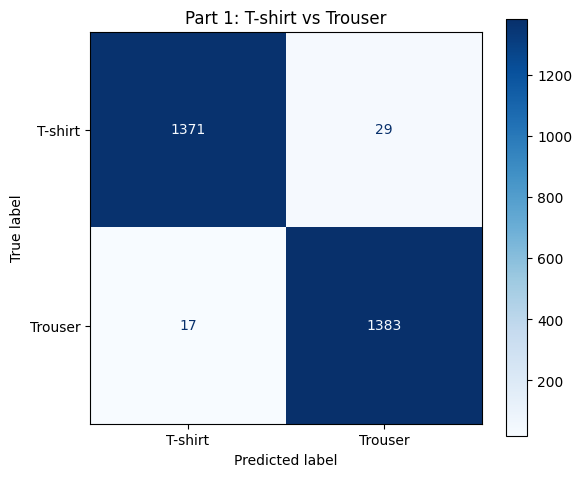

In [10]:
# Visualize results (provided - not part of assignment)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['T-shirt', 'Trouser']).plot(ax=ax, cmap='Blues')
ax.set_title('Part 1: T-shirt vs Trouser')
plt.tight_layout()
plt.show()

---

## Part 2: Multi-class Classification with Cross-Validation

**Task:** Classify footwear types: Sandal (5) vs Sneaker (7) vs Ankle boot (9)

Compare three models using 5-fold cross-validation. Select the best model and evaluate on test set.

**Required outputs:**
- `output/part2_cv_results.csv` - columns: `model`, `fold`, `score`
- `output/part2_test_results.csv` - classification report as DataFrame

In [17]:
print("\nPart 2: Multi-class Classification with CV")
print("-" * 40)

# TODO: Load data, filter to labels 5, 7, 9
# TODO: Encode labels to 0, 1, 2 using LabelEncoder (required for XGBoost)
# TODO: Train/test split with stratification
# TODO: Scale features
X, y = load_fashion_mnist()
mask = np.isin(y, [5, 7, 9])
X_filtered = X[mask]
y_filtered = y[mask]
# Encode labels to 0, 1, 2
label_encoder = LabelEncoder()
y_filtered_encoded = label_encoder.fit_transform(y_filtered)
# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered_encoded, test_size=0.2, random_state=42, stratify=y_filtered_encoded
)
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Models to compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1)
}

# TODO: Run 5-fold CV for each model (use StratifiedKFold, scoring='accuracy')
# Run 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    for fold, score in enumerate(scores, 1):
        cv_results.append({
            'model': model_name,
            'fold': fold,
            'score': score
        })
    print(f"{model_name}: {scores.mean():.4f} (+/- {scores.std():.4f})")
    
    
# TODO: Save CV results to part2_cv_results.csv
cv_df = pd.DataFrame(cv_results)
cv_df.to_csv(os.path.join(OUTPUT_DIR, "part2_cv_results.csv"), index=False)

# TODO: Find best model by mean CV score
mean_scores = cv_df.groupby('model')['score'].mean()
best_model_name = mean_scores.idxmax()
print(f"\nBest model: {best_model_name} (mean CV accuracy: {mean_scores[best_model_name]:.4f})")

# TODO: Retrain best model on full training data
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)
# TODO: Evaluate on test set, save classification_report to part2_test_results.csv
y_pred = best_model.predict(X_test_scaled)
report_dict = classification_report(y_test, y_pred, output_dict=True, target_names=['Sandal', 'Sneaker', 'Ankle boot'])

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(OUTPUT_DIR, "part2_test_results.csv"))

print("\nTest Set Classification Report:")
print(report_df)


Part 2: Multi-class Classification with CV
----------------------------------------
LogisticRegression: 0.9274 (+/- 0.0063)
RandomForest: 0.9524 (+/- 0.0039)
XGBoost: 0.9670 (+/- 0.0033)

Best model: XGBoost (mean CV accuracy: 0.9670)

Test Set Classification Report:
              precision    recall  f1-score      support
Sandal         0.983465  0.977143  0.980294  1400.000000
Sneaker        0.952113  0.965714  0.958865  1400.000000
Ankle boot     0.969042  0.961429  0.965221  1400.000000
accuracy       0.968095  0.968095  0.968095     0.968095
macro avg      0.968207  0.968095  0.968127  4200.000000
weighted avg   0.968207  0.968095  0.968127  4200.000000


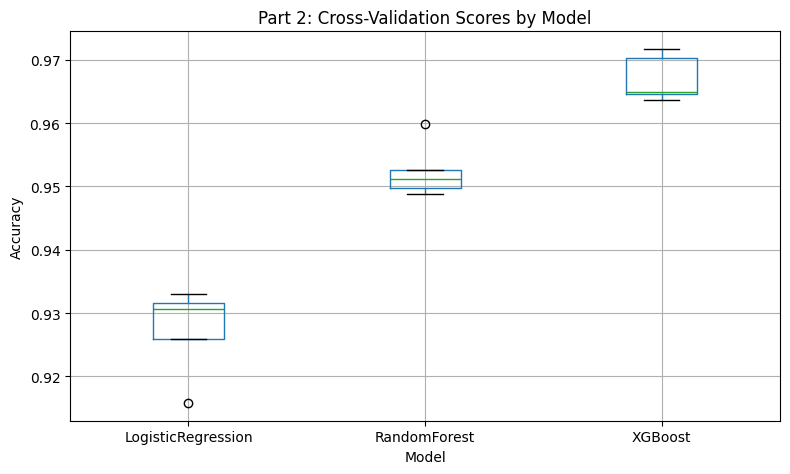

In [ ]:
# Visualize CV results (provided - not part of assignment)
import matplotlib.pyplot as plt

try:
    fig, ax = plt.subplots(figsize=(8, 5))
    cv_df.boxplot(column='score', by='model', ax=ax)
    ax.set_title('Part 2: Cross-Validation Scores by Model')
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    plt.suptitle('')  # Remove automatic title
    plt.tight_layout()
    plt.show()
except NameError:
    print("cv_df not defined yet - complete the TODOs above first!")

---

## Part 3: Full Model Comparison Pipeline

**Task:** Classify Clothing vs Footwear (binary)

- **Clothing (0):** T-shirt, Trouser, Pullover, Dress, Coat, Shirt (labels 0-4, 6)
- **Footwear (1):** Sandal, Sneaker, Ankle boot (labels 5, 7, 9)
- **Exclude:** Bag (label 8)

Compare 3 models using AUC, generate ROC curves, evaluate best model.

**Required outputs:**
- `output/part3_cv_results.csv` - columns: `model`, `fold`, `auc`
- `output/part3_test_results.csv` - columns: `model`, `accuracy`, `auc`
- `output/part3_roc_curves.png` - use `plot_roc_curves()` from helpers
- `output/part3_confusion_matrix.png` - use `plot_confusion_matrix()` from helpers

In [ ]:
print("\nPart 3: Full Model Comparison Pipeline")
print("-" * 40)

# TODO: Load data, filter out bags (label 8)
X, y = load_fashion_mnist()
mask = y != 8  # Exclude bags
X_filtered = X[mask]
y_original = y[mask]

# TODO: Create binary lab
y_binary = np.isin(y_original, [5, 7, 9]).astype(int)

# TODO: Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)
# TODO: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1)
}

# TODO: Run 5-fold CV for all models (use StratifiedKFold, scoring='roc_auc')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    for fold, score in enumerate(scores, 1):
        cv_results.append({
            'model': model_name,
            'fold': fold,
            'auc': score
        })
    print(f"{model_name}: {scores.mean():.4f} (+/- {scores.std():.4f})")
# TODO: Save CV results to part3_cv_results.csv
cv_df = pd.DataFrame(cv_results)
cv_df.to_csv(os.path.join(OUTPUT_DIR, "part3_cv_results.csv"), index=False)
# TODO: Find best model by mean AUC
mean_auc = cv_df.groupby('model')['auc'].mean()
best_model_name = mean_auc.idxmax()
# TODO: Train ALL models on full training data (needed for ROC curves)
trained_models = {}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    trained_models[model_name] = model
    print(f"  {model_name} trained")
# TODO: Generate ROC curves: plot_roc_curves(trained_models, X_test_scaled, y_test, save_path)
plot_roc_curves(
    trained_models,
    X_test_scaled,
    y_test,
    os.path.join(OUTPUT_DIR, "part3_roc_curves.png")
)
# TODO: Evaluate best model on test set (accuracy and AUC)
best_model = trained_models[best_model_name]
y_pred = best_model.predict(X_test_scaled)
proba = best_model.predict_proba(X_test_scaled)
pos_col = list(best_model.classes_).index(1)
y_pred_proba = proba[:, pos_col]
test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nBest Model Test Performance:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  AUC: {test_auc:.4f}")
# TODO: Generate confusion matrix: plot_confusion_matrix(y_test, y_pred, ['Clothing', 'Footwear'], save_path)
y_test = (np.asarray(y_test) == 1).astype(int)
y_pred = (np.asarray(y_pred) == 1).astype(int)
plot_confusion_matrix(
    y_test,
    y_pred,
    ['Clothing', 'Footwear'],
    os.path.join(OUTPUT_DIR, "part3_confusion_matrix.png")
)
# TODO: Save test results to part3_test_results.csv
test_results = pd.DataFrame([{
    'model': best_model_name,
    'accuracy': test_accuracy,
    'auc': test_auc
}])
test_results.to_csv(os.path.join(OUTPUT_DIR, "part3_test_results.csv"), index=False)



Part 3: Full Model Comparison Pipeline
----------------------------------------
LogisticRegression: 0.9997 (+/- 0.0001)
RandomForest: 1.0000 (+/- 0.0000)
XGBoost: 1.0000 (+/- 0.0000)
  LogisticRegression trained
  RandomForest trained
  XGBoost trained

Best Model Test Performance:
  Accuracy: 0.9994
  AUC: 1.0000


---

## Validation

In [ ]:
# Run in terminal: pytest .github/tests/ -v
print("Run 'pytest .github/tests/ -v' in your terminal to check your work.")